### Introduction
Generative Adversarial Networks (GAN's) are a powerful tool that allows the generation of images from noise or seed images.  GAN's work by simultaneously training one network to generate random images (the generator) and another network to discriminate between the fake images and real images (the discriminator).  

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display
import imageio

### Data
Two data directories are provided.  The first contains 300 Monet paintings sized 256x256 pixels.  The second contains 7038 photos that can be used as seeds.  The first image from each directory is shown below.

monet files: 300 image size: (256, 256)


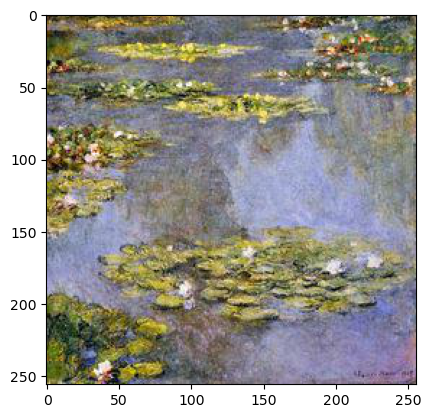

photo files: 7038 image size: (256, 256)


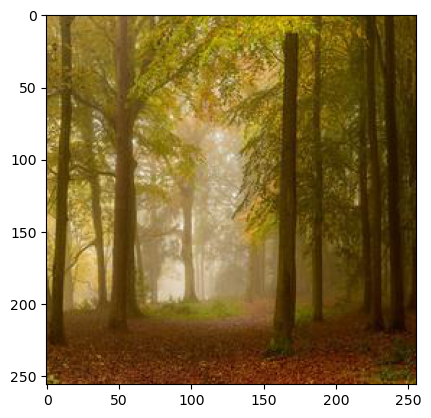

In [2]:
monet_dir = '../input/gan-getting-started/monet_jpg'
photo_dir = '../input/gan-getting-started/photo_jpg'
monet_files = os.listdir(monet_dir)
photo_files = os.listdir(photo_dir)
with Image.open(monet_dir + '/'+ monet_files[0]) as im:
    print(f'monet files: {len(monet_files)} image size: {im.size}')
    #print(np.asarray(im))
    plt.imshow(im)
    plt.show()
with Image.open(photo_dir + '/'+ photo_files[0]) as im:
    print(f'photo files: {len(photo_files)} image size: {im.size}')
    plt.imshow(im)
    plt.show()

In [3]:
photo_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(photo_dir),
    labels=None,
    batch_size=16,
    image_size=(256,256),
    shuffle=True,
    seed=None)

Found 7038 files belonging to 1 classes.


In [4]:
monet_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(monet_dir),
    labels=None,
    batch_size=16,
    image_size=(256,256),
    shuffle=True,
    #color_mode = 'rgb',
    seed=None)

Found 300 files belonging to 1 classes.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
monet_pipe = monet_ds.cache().prefetch(buffer_size=AUTOTUNE)
photo_pipe = photo_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building
The basic GAN structure used here was adapted from the tensorflow GAN tutorial at https://www.tensorflow.org/tutorials/generative/dcgan.  The original code was adapted for 256x256 rgb outputs from the original 28x28 greyscale.  Adaptation required additional layers for image sizing and 256x256x3 seeds that were generated from a truncated normal distribution.  The generator model is below and uses 4 inverse conv2D layers and a dense layer to map from the seed.

In [6]:
def make_generator():
    model = tf.keras.Sequential([
        layers.Rescaling(1./255, input_shape=(256,256,3)),
        layers.Conv2DTranspose(256, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, (3,3), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(3, (3,3), strides=(1,1), padding='same', use_bias=False)
    ])
    return model

Generator architecture and untrained image generated.

In [7]:
generator = make_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 256)    19200     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 256)    1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256, 256, 256)     0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 128)    819200    
 ranspose)                                                       
                                                        

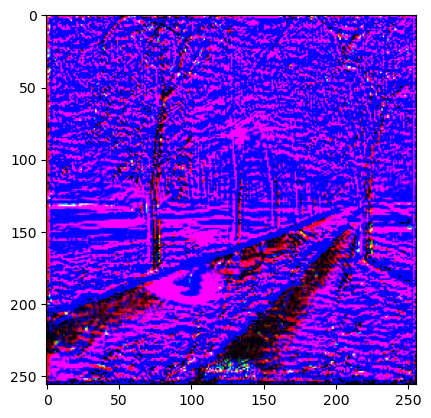

(16, 256, 256, 3)


In [8]:
seed = list(photo_pipe.take(1).as_numpy_iterator())[0]
generated_image = generator(seed, training=False)

plt.imshow(generated_image[0, :, :, :]*255)
plt.show()
print(generated_image.shape)
#print(generated_image[0,:,:,:])

In [9]:
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 3, activation='relu', strides=(2,2), input_shape=[256, 256, 3]), #128
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #64
        layers.Conv2D(128,3, activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #32
        layers.Conv2D(128,3, activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #16
        layers.Conv2D(256,3, activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #8
        layers.Conv2D(256,3, activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #4
        layers.Flatten(),
        layers.Dense(1)
    ])

    return model

In [10]:
discriminator = make_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)     

The loss was set to cross entropy, which was what was used in the tutorial.  

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
EPOCHS = 12

In [14]:
#@tf.function
def train_step(target_images, input_images):
    #noise = tf.random.truncated_normal([16, noise_dim], mean=0.5, stddev=0.25)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(input_images, training=True)

        real_output = discriminator(target_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :]*255)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    return fig

In [16]:
#train_iterator = train_dataset.as_numpy_iterator()
#one_batch = train_iterator.next()
#model(one_batch)

def train(target_images, input_images, epochs):
    for epoch in range(epochs):
        start = time.time()
        input_iterator = input_images.as_numpy_iterator()
        epoch_string = f'epoch: {epoch}'
        print(epoch_string)
        i = 0
        for image_batch in target_images.as_numpy_iterator():
            input_batch = input_iterator.next()
            train_step(image_batch, input_batch)
            print(f'{epoch_string}  batch completed: {i}')
            #plt.show(image)
            i += 1

        # Produce images for the GIF as you go
        #display.clear_output(wait=True)
        image = generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    image = generate_and_save_images(generator,
                           epochs,
                           seed)

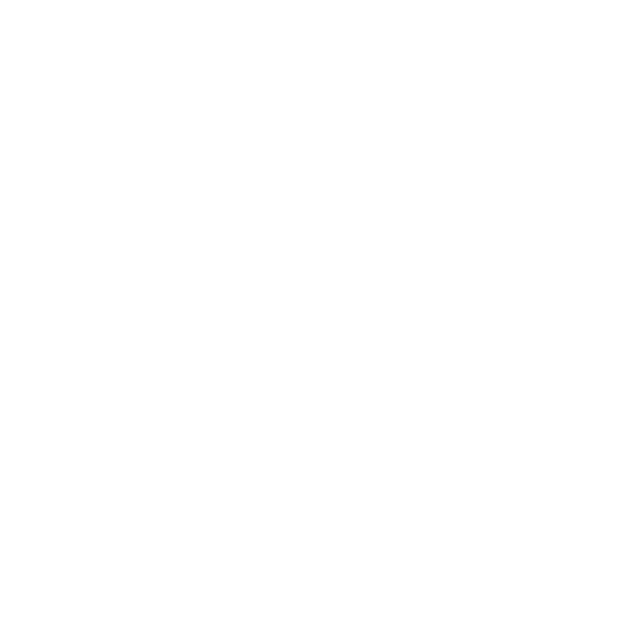

In [17]:
train(monet_pipe, photo_pipe, EPOCHS)

In [18]:
'''anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)'''

"anim_file = 'dcgan.gif'\n\nwith imageio.get_writer(anim_file, mode='I') as writer:\n    filenames = glob.glob('image*.png')\n    filenames = sorted(filenames)\n    for filename in filenames:\n        image = imageio.imread(filename)\n        writer.append_data(image)\n    image = imageio.imread(filename)\n    writer.append_data(image)\n    \nimport tensorflow_docs.vis.embed as embed\nembed.embed_file(anim_file)"